<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Fastai_Transfomers_inspired_by_blurr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GET STARTED

In [1]:
!pip install transformers
!pip install fastai2

     |████████████████████████████████| 645kB 6.6MB/s 
     |████████████████████████████████| 890kB 12.8MB/s 
     |████████████████████████████████| 3.8MB 42.9MB/s 
     |████████████████████████████████| 1.0MB 47.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=469e51b564e510e61214d86bc1e2deab0999fedd319c9ca7a8184c7ea2a8c6fd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 194kB 6.9MB/s 


In [0]:
import sys, inspect
from enum import Enum

import pandas as pd
import torch

from transformers import *
from fastai2.text.all import *

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_name()

'Tesla K80'

## PREP HELP FUNCTION

In [0]:
def str_to_class(classname):
  "converts string representation to class"
  return getattr(sys.modules[__name__], classname)

In [0]:
class Singleton:
  def __init__(self, cls):
    self._cls, self._instance = cls, None
  
  def __call__(self, *args, **kwargs):
    if self._instance == None: self._instance = self._cls(*args, **kwargs)
    return self._instance

In [0]:
@Singleton
class ModelHelper():
    
    def __init__(self):
        # get hf classes (tokenizers, configs, models, etc...)
        transformer_classes = inspect.getmembers(sys.modules[__name__], 
                                                 lambda member: inspect.isclass(member)
                                                 and member.__module__.startswith('transformers.'))
        
        # build a df that we can query against to get various transformers objects/info
        self._df = pd.DataFrame(transformer_classes, columns=['class_name', 'class_location'])
        
        # add the module each class is included in
        self._df['module'] = self._df.class_location.apply(lambda v: v.__module__)
        
        # remove class_location (don't need it anymore)
        self._df.drop(labels=['class_location'], axis=1, inplace=True)
        
        # break up the module into separate cols
        module_parts_df = self._df.module.str.split(".", n = -1, expand = True) 
        for i in range(len(module_parts_df.columns)):
            self._df[f'module_part_{i}'] = module_parts_df[i]

        # using module part 1, break up the functional area and arch into separate cols
        module_part_1_df = self._df.module_part_1.str.split("_", n = 1, expand = True) 
        self._df[['functional_area', 'arch']] = module_part_1_df
        
        # if functional area = modeling, pull out the task it is built for
        model_type_df = self._df[(self._df.functional_area == 'modeling')].class_name.str.split('For', n=1, expand=True)
        
        model_type_df[1] = np.where(model_type_df[1].notnull(), 
                                    'For' + model_type_df[1].astype(str), 
                                    model_type_df[1])
        
        self._df['model_task'] = model_type_df[1]
        
        model_type_df = self._df[(self._df.functional_area == 'modeling')].class_name.str.split('With', n=1, expand=True)
        model_type_df[1] = np.where(model_type_df[1].notnull(), 
                                    'With' + model_type_df[1].astype(str), 
                                    self._df[(self._df.functional_area == 'modeling')].model_task)
        
        self._df['model_task'] = model_type_df[1]
        
        # look at what we're going to remove (use to verify we're just getting rid of stuff we want too)
        # df[~df['hf_class_type'].isin(['modeling', 'configuration', 'tokenization'])]
        
        # only need these 3 functional areas for our querying purposes
        self._df = self._df[self._df['functional_area'].isin(['modeling', 'configuration', 'tokenization'])]
        
    def get_architectures(self): 
        """Used to get all the architectures supported by your `Transformers` install"""
        return self._df[(self._df.arch.notna()) & (self._df.arch != None)].arch.unique().tolist()
    
    def get_config(self, arch): 
        """Used the locate the name of the configuration class for a given architecture"""
        return self._df[(self._df.functional_area == 'configuration') & (self._df.arch == arch)].class_name.values[0]
    
    def get_tokenizers(self, arch): 
        """Used to get the available huggingface tokenizers for a given architecture. Note: There may be 
        multiple tokenizers and so this returns a list.
        """
        return self._df[(self._df.functional_area == 'tokenization') & (self._df.arch == arch)].class_name.values
    
    def get_tasks(self, arch=None): 
        """Get the type of tasks for which there is a custom model for (*optional: by architecture*). 
        There are a number of customized models built for specific tasks like token classification, 
        question/answering, LM, etc....
        """
        query = ['model_task.notna()']
        if (arch): query.append(f'arch == "{arch}"')

        return self._df.query(' & '.join(query), engine='python').model_task.unique().tolist()
    
    def get_models(self, arch=None, task=None):
        """The transformer models available for use (optional: by architecture | task)"""
        query = ['functional_area == "modeling"']
        if (arch): query.append(f'arch == "{arch}"')
        if (task): query.append(f'model_task == "{task}"')

        return self._df.query(' & '.join(query)).class_name.tolist()
    
    def get_classes_for_model(self, model_name_or_enum):
        """Get tokenizers, config, and model for a given model name / enum"""
        model_name = model_name_or_enum if isinstance(model_name_or_enum, str) else model_name_or_enum.name

        meta = self._df[self._df.class_name == model_name]
        tokenizers = self.get_tokenizers(meta.arch.values[0])
        config = self.get_config(meta.arch.values[0])

        return ([str_to_class(tok) for tok in tokenizers], str_to_class(config), str_to_class(model_name))
    
    def get_model_architecture(self, model_name_or_enum):
        """Get the architecture for a given model name / enum"""
        model_name = model_name_or_enum if isinstance(model_name_or_enum, str) else model_name_or_enum.name
        return self._df[self._df.class_name == model_name].arch.values[0]
    
    def get_auto_hf_objects(self, pretrained_model_name_or_path, task, config=None):
        """Returns the architecture (str), tokenizer (obj), config (obj), and model (obj) 
        given a known pre-trained model name or path and a task using Hugginface `AutoModel` capabilities.  
        If a `config` is passed in, it will be  used when building the model, else the default configuration 
        will be used (e.g., `AutoConfig.from_pretrained(...)`)
        """
        tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path)
        config = AutoConfig.from_pretrained(pretrained_model_name_or_path) if (config is None) else config

        model = str_to_class(f'AutoModel{task.name}').from_pretrained(pretrained_model_name_or_path, 
                                                                      config=config)
        arch = self.get_model_architecture(type(model).__name__)

        return (arch, tokenizer, config, model)
    
    def get_hf_objects(self, pretrained_model_name_or_path, tokenizer_cls, model_cls, config=None): 
        """Returns the architecture (str), tokenizer (class), config (class), and model (class) 
        given a known pre-trained model name or path, a tokenizer class, and model class.  If a `config` object 
        is passed in, it will be used when building the model, else the default configuration will be used.
        """
        tokenizer = tokenizer_cls.from_pretrained(pretrained_model_name_or_path)

        if (config is None):
            model = str_to_class(model_cls.name).from_pretrained(pretrained_model_name_or_path)
            config = model.config
        else:
            model = str_to_class(model_cls.name).from_pretrained(pretrained_model_name_or_path, config=config)

        arch = self.get_model_architecture(type(model).__name__)

        return (arch, tokenizer, config, model)

In [0]:
MODEL_HELPER = ModelHelper()

In [0]:
HF_ARCHITECTURES = Enum('HF_ARCHITECTURES', MODEL_HELPER.get_architectures())

In [18]:
L(HF_ARCHITECTURES)

(#40) [<HF_ARCHITECTURES.transfo_xl: 1>,<HF_ARCHITECTURES.albert: 2>,<HF_ARCHITECTURES.auto: 3>,<HF_ARCHITECTURES.bart: 4>,<HF_ARCHITECTURES.bert: 5>,<HF_ARCHITECTURES.bert_japanese: 6>,<HF_ARCHITECTURES.ctrl: 7>,<HF_ARCHITECTURES.camembert: 8>,<HF_ARCHITECTURES.utils: 9>,<HF_ARCHITECTURES.distilbert: 10>...]

In [0]:
HF_TASKS_ALL = Enum('HF_TASKS_ALL', MODEL_HELPER.get_tasks())
HF_TASKS_AUTO = Enum('HF_TASKS_AUTO', MODEL_HELPER.get_tasks('auto'))

In [20]:
L(HF_TASKS_ALL)

(#12) [<HF_TASKS_ALL.ForMaskedLM: 1>,<HF_TASKS_ALL.ForQuestionAnswering: 2>,<HF_TASKS_ALL.ForSequenceClassification: 3>,<HF_TASKS_ALL.ForTokenClassification: 4>,<HF_TASKS_ALL.ForMultipleChoice: 5>,<HF_TASKS_ALL.ForPreTraining: 6>,<HF_TASKS_ALL.WithLMHead: 7>,<HF_TASKS_ALL.ForConditionalGeneration: 8>,<HF_TASKS_ALL.ForNextSentencePrediction: 9>,<HF_TASKS_ALL.ForQuestionAnsweringSimple: 10>...]

In [21]:
L(HF_TASKS_AUTO)

(#6) [<HF_TASKS_AUTO.ForMultipleChoice: 1>,<HF_TASKS_AUTO.ForPreTraining: 2>,<HF_TASKS_AUTO.ForQuestionAnswering: 3>,<HF_TASKS_AUTO.ForSequenceClassification: 4>,<HF_TASKS_AUTO.ForTokenClassification: 5>,<HF_TASKS_AUTO.WithLMHead: 6>]

In [0]:
HF_MODELS = Enum('HF_MODELS', MODEL_HELPER.get_models())

In [23]:
L(HF_MODELS)

(#193) [<HF_MODELS.AdaptiveEmbedding: 1>,<HF_MODELS.AlbertForMaskedLM: 2>,<HF_MODELS.AlbertForQuestionAnswering: 3>,<HF_MODELS.AlbertForSequenceClassification: 4>,<HF_MODELS.AlbertForTokenClassification: 5>,<HF_MODELS.AlbertModel: 6>,<HF_MODELS.AlbertPreTrainedModel: 7>,<HF_MODELS.AutoModel: 8>,<HF_MODELS.AutoModelForMultipleChoice: 9>,<HF_MODELS.AutoModelForPreTraining: 10>...]

In [53]:
task = HF_TASKS_AUTO.ForSequenceClassification
print(task.name)
pretrained_model_name = "roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_tokenizer, hf_config, hf_model = MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)

ForSequenceClassification


## DATA

In [0]:
# path = untar_data(URLs.IMDB_SAMPLE)
# path.ls()

In [0]:
# imdb_df = pd.read_csv(path/'texts.csv')
# imdb_df.info()

In [0]:
# path = untar_data(URLs.IMDB)

path.ls()

In [0]:
(path/'train').ls()

In [0]:
# Download the IMDB data from kaggle

In [24]:
!pip install kaggle

In [28]:
!mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json
token = {"username":"binliu0630","key":"8fbf745edbb9799f7f8f45f516701290"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [34]:

!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [36]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 66% 17.0M/25.7M [00:00<00:00, 20.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 47.7MB/s]


In [0]:
!cd {/content}/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [38]:
!ls {/content}/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip


In [39]:
!unzip {/content}/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/imdb-dataset-of-50k-movie-reviews.zip

Archive:  {/content}/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [0]:
imdb_df = pd.read_csv('IMDB Dataset.csv')

In [41]:
imdb_df.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive


In [0]:
model_path = Path('models') 


In [0]:
class HF_BaseInput(list): pass

In [0]:
#export
class HF_Tokenizer():
    """huggingface friendly tokenization function."""
    def __init__(self, hf_arch, hf_tokenizer, mode='str', list_split_func=str.split, **kwargs):
        store_attr(self, 'hf_arch, hf_tokenizer, mode, list_split_func')

    def __call__(self, items): 
        for txt in items: yield self._tokenize(txt)

    def _tokenize(self, txt):   
        if (self.mode == 'str'): 
            return self.hf_tokenizer.tokenize(txt)
        
        if (self.mode == 'list'):
            try: tokens = ast.literal_eval(txt)
            except: 
                tokens = self.list_split_func(txt)
            finally:
                return [sub_toks for entity in tokens for sub_toks in self.hf_tokenizer.tokenize(entity)]

In [0]:
@typedispatch
def build_hf_input(task, tokenizer, a_tok_ids, b_tok_ids=None, targets=None,
                   max_length=512, pad_to_max_length=True, truncation_strategy='longest_first'):

    res = tokenizer.prepare_for_model(a_tok_ids, b_tok_ids, 
                                       max_length=max_length, pad_to_max_length=pad_to_max_length,
                                       truncation_strategy=truncation_strategy, return_tensors='pt')
    
    input_ids = res['input_ids'][0]
    token_type_ids = res['token_type_ids'][0] if ('token_type_ids' in res) else torch.tensor([-9999]) 
    attention_mask = res['attention_mask'][0] if ('attention_mask' in res) else torch.tensor([-9999]) 
    
    return HF_BaseInput([input_ids, token_type_ids, attention_mask]), targets

In [0]:
class HF_BatchTransform(Transform):
    """Handles everything you need to assemble a mini-batch of inputs and targets"""
    def __init__(self, hf_arch, hf_tokenizer, max_seq_len=512, truncation_strategy='longest_first', task=None):
        
        self.hf_arch = hf_arch
        self.hf_tokenizer = hf_tokenizer
        store_attr(self, 'max_seq_len, truncation_strategy, task')
        
    def encodes(self, samples):
        
        encoded_samples = []
        for idx, sample in enumerate(samples):
            
            if (isinstance(sample[0], tuple)):
                a_tok_ids = sample[0][0].tolist()
                b_tok_ids = sample[0][1].tolist()
            else:
                a_tok_ids = sample[0].tolist()
                b_tok_ids = None

            hf_base_input, targets = build_hf_input(self.task, self.hf_tokenizer, 
                                                    a_tok_ids, b_tok_ids, sample[1:],
                                                    self.max_seq_len, True, self.truncation_strategy)
            
            encoded_samples.append((hf_base_input, *targets))
            
        return encoded_samples

In [0]:
class HF_TextBlock(TransformBlock):
    
    @delegates(Numericalize.__init__)
    def __init__(self, tok_tfms, hf_arch, hf_tokenizer, hf_batch_tfm=None, vocab=None, task=None,
                 max_seq_len=512, **kwargs):

        if hf_batch_tfm is None:
            hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len,
                                             truncation_strategy='longest_first', task=task)
            
        return super().__init__(type_tfms=[*tok_tfms, Numericalize(vocab, **kwargs)],
                                dl_type=SortedDL, 
                                dls_kwargs={ 'before_batch': hf_batch_tfm })

    @classmethod
    @delegates(Tokenizer.from_df, keep=True)
    def from_df(cls, text_cols_lists, hf_arch, hf_tokenizer, hf_batch_tfm=None, vocab=None, task=None, 
                tok_func_mode='str', res_col_names=None, max_seq_len=512, **kwargs):
        """Creates a HF_TextBlock via a pandas DataFrame"""
        
        # grab hf tokenizer class to do the actual tokenization (via tok_func) and its vocab
        tokenizer_cls = partial(HF_Tokenizer, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, mode=tok_func_mode)
        if (vocab is None): vocab = list(hf_tokenizer.get_vocab())

        # build the column name(s) returned after tokenization
        if (res_col_names is None): res_col_names = [ f'text{i}' for i in range(len(text_cols_lists)) ] 
    
        tok_tfms = [ Tokenizer.from_df(text_cols, 
                                       res_col_name=res_col_name, 
                                       tok_func=tokenizer_cls,
                                       rules=[], **kwargs) 
                    for text_cols, res_col_name in zip(text_cols_lists, res_col_names) ]
  
        return cls(tok_tfms, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, hf_batch_tfm=hf_batch_tfm, 
                   vocab=vocab, task=task, max_seq_len=max_seq_len)

In [54]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['review']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    CategoryBlock
)

def get_x(x): return x.text0

#dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('label'), splitter=ColSplitter(col='is_valid'))
dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('sentiment'), splitter=RandomSplitter(0.2))

dls = dblock.dataloaders(imdb_df, bs=4)

In [0]:
@typedispatch
def show_batch(x:HF_BaseInput, y, samples, hf_tokenizer, skip_special_tokens=True, ctxs=None, max_n=6, **kwargs):        
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
    
    samples = L((TitledStr(hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')),*s[1:]) 
                for inp, s in zip(x[0], samples))
    
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)

    display_df(pd.DataFrame(ctxs))
    return ctxs

In [83]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, but Spike knocked the table over right before his brother came crashing down! Guerrero and Benoit propped another table in the corner and tried to Irish Whip Spike through it, but Bubba dashed in and blocked his brother. Bubba caught fire and lifted both opponents into back body drops! Bubba slammed Guerrero and Spike stomped on the Wolverine from off the top rope. Bubba held Benoit at bay for Spike to soar into the Wassup! headbutt! Shortly after, Benoit latched Spike in the Crossface, but the match continued even after Spike tapped out. Bubba came to his brother's rescue and managed to sprawl Benoit on a table. Bubba leapt from the middle rope, but Benoit moved and sent Bubba crashing through the wood! But because his opponents didn't force him through the table, Bubba was allowed to stay in the match. The first man was eliminated shortly after, though, as Spike put Eddie through a table with a Dudley Dawg from the ring apron to the outside! Benoit put Spike through a table moments later to even the score. Within seconds, Bubba nailed a Bubba Bomb that put Benoit through a table and gave the Dudleys the win! Winner: Bubba Ray and Spike Dudley<br /><br />Match 2: Cruiserweight Championship Jamie Noble vs Billy Kidman Billy Kidman challenged Jamie Noble, who brought Nidia with him to the ring, for the Cruiserweight",positive
1,"My first impresson of the Saikano: Live Action movie trailer (viewable on YouTube), was ""Wow, this could be perhaps one of the few better live-action anime adaptations.""<br /><br />This time I was just wrong! Simply put, the live-action Saikano movie was a puzzle missing a number of pieces; put together just enough to get the vague image of it all.<br /><br />*STORY* <br /><br />The movies story vaguely follows the anime and manga, but the movies story is just the frame of a car, rather than a complete automobile. It seems that many parts of the story originally in the anime were left out, altered, or completely changed. In fact the ending is completely different from the manga or anime endings. <br /><br />Characters especially; many left out or had a different feel. The connection between Fuyumi and Shuji is reduced to that of Shuji knowing her because she's the video store lady. Chise's character felt too strong already and only uttered the infamous I'm sorry a few times in the movie. Same can be said with Shuji. We lost the shy uptight yet tall male lead, the song he hums, and his frequent action of calling Chise silly. Other characters like Tetsu and Akemi had a different, toned down feel to them. Perhaps the dropping and toning down of other characters was to focus a lot more on Chise and Shuji, which it did. Way too much. Expecting a lot of sweet action scenes like those in the trailer? Well don't! Those in the trailer plus a few minutes, is the only amount of action you will get. So much of the movie is talking that while I was browsing thru the movie before watching it all, I thought I had gotten 

# MODEL

ForSequenceClassification


In [50]:
hf_arch

'roberta'

In [0]:
def hf_splitter(m):
    """Splits the huggingface model based on various model architecture conventions"""
    model = m.hf_model if (hasattr(m, 'hf_model')) else m
    root_modules = list(model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [0]:
class HF_BaseModelCallback(Callback):
    
    def begin_fit(self):
        self.hf_model = self.model
        self.hf_model_fwd_args = self.model.forward.__code__.co_varnames
    
    def begin_batch(self):
        x = self.xb[0]
        model_args = [x[0]]
        if (self._include_arg('attention_mask', x[2])): model_args.append(x[2])
        if (self._include_arg('token_type_ids', x[1])): model_args.append(x[1])

        self.learn.xb = tuplify(model_args)
    
    def after_pred(self): 
        self.learn.pred = self.pred[0]
        
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

In [87]:

learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.create_opt() 
learn.freeze()

learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.468034,0.295785,0.882900,17:06
1,0.443764,0.275600,0.890000,17:03
2,0.314005,0.253279,0.897800,17:08


In [0]:

#export
@typedispatch
def show_results(x:HF_BaseInput, y, samples, outs, hf_tokenizer, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):        
    
    if ctxs is None: ctxs = get_empty_df(min(len(samples), max_n))
        
    samples = samples = L((TitledStr(hf_tokenizer.decode(inp, skip_special_tokens=skip_special_tokens).replace(hf_tokenizer.pad_token, '')),*s[1:]) 
                          for inp, s in zip(x[0], samples))
    
    ctxs = show_batch[object](x, y, samples, max_n=max_n, ctxs=ctxs, **kwargs)

    n_preds_per_input = len(outs[0])
    if (n_preds_per_input == 1): 
        for i,ctx in enumerate(ctxs): ctx['target'] = outs[i][0]
    else:
        for pred_idx in range(n_preds_per_input):
            for i,ctx in enumerate(ctxs):  ctx[f'target{pred_idx+1}'] = outs[i][pred_idx]
        
    display_df(pd.DataFrame(ctxs))
    return ctxs

In [92]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=5)

,text,category,target
0,"Some have praised _Atlantis:_The_Lost_Empire_ as a Disney adventure for adults. I don't think so--at least not for thinking adults.<br /><br />This script suggests a beginning as a live-action movie, that struck someone as the type of crap you cannot sell to adults anymore. The ""crack staff"" of many older adventure movies has been done well before, (think _The Dirty Dozen_) but _Atlantis_ represents one of the worse films in that motif. The characters are weak. Even the background that each member trots out seems stock and awkward at best. An MD/Medicine Man, a tomboy mechanic whose father always wanted sons, if we have not at least seen these before, we have seen mix-and-match quirks before. The story about how one companion, Vinny played by Don Novello (Fr. Guido Sarducci), went from flower stores to demolitions totally unconvincing.<br /><br />Only the main character, Milo Thatch, a young Atlantis-obsessed academic voiced by Michael J. Fox, has any depth to him. Milo's search for Atlantis continues that of his grandfather who raised him. The opening scene shows a much younger Milo giddily perched on a knee, as his grandfather places his pith helmet on his head.<br /><br />And while the characters were thin at best, the best part about _Atlantis_ was the voice talent. Perhaps Milo's depth is no thicker than Fox's charm. Commander Rourke loses nothing being voiced by James Garner. Although Rourke is a pretty stock military type, Garner shows his ability to breath life into characters simply by his delivery. Garner's vocal performance is the high point. I'm sorry to say Leonard Nimoy's Dying King is nothing more than obligatory. Additionally, Don Novello as the demolition expert, Vinny Santorini, was also notable for one or two well-done, funny lines--but I've always liked Father Guido Sarducci, anyway. <br /><br />Also well done was the Computer Animation. The BACKGROUND animation, that is. The character animation has not been this bad for Disney since the minimalism that drove Don Bluth out the door. The character animation does nothing if not make already flat characters appear even flatter. Aside from landscapes, buildings and vehicles there isn't much to impress.<br /><br />The plot was the worst. Some",negative,negative
1,"It is the early morning of our discontent, and some friends of mine and I have just gotten through watching ""The Wind."" Truly a disaster film. Not in the sense of forces of nature wreaking havoc on an unsuspecting populace, but rather an awful movie wreaking havoc on an unsuspecting audience. To give you an indication of how frustrating it was to watch this particular bomb, I'll give you an example quoted during my first pained viewing. If given the choice of watching this movie for a second time and, say, boiling myself, I'm afraid to say the choice would not be an immediate one. But rather than simply ranting ""ad peliculam"" with lousy one-liners, I'm going to get specific as to why exactly my friends and I panned this particular film.<br /><br />To start this off, I like low-budget horror flicks. I even like artsy, low-budget horror flicks. I liked ""Cold Hearts"", ""Midnight Mass,"" ""Jugular Wine,"" etc. Films that were ambitious and daring, even if they were lacking in production value, execution and even acting. Generally, an interesting premise, unusual camera technique or merely just a well done scene or two will save a movie that is running a little rough around the edges. With these provisos in mind, I would like to say conclusively that I hated ""The Wind.""<br /><br />The movie was probably most disappointing in the sense that it was incredibly frustrating to watch. From the actions of the main characters, to the flow (?) of the plot, to the big portents hinted at by the opening which ultimately aspired to dust (and did not even attach themselves logically to what transpired in the remainder of the film, and left the viewer, expecting something more, with a se

In [93]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.175026,0.151030,0.942400,49:16
1,0.083956,0.128934,0.958200,49:08


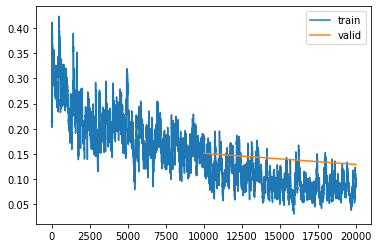

In [94]:
learn.recorder.plot_loss()

## Multi-class: Emotion classification

In [55]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2020-05-10 20:57:49--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2020-05-10 20:57:49--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2d6322e0c63ef70fec7a31d5a6.dl.dropboxusercontent.com/cd/0/inline/A3f7GZJ2vN3sa22fiJvMr8QgHqf09sVtmfSVw-wdorUKgexzDtEu-6QYUJ8ut2uE9Aee4oNWlyA03tE9lfZfoC5GsrLjDQVe7sSTgPzjEE5p8-k2xMTDo3FbfV5CtmbAnfA/file# [following]
--2020-05-10 20:57:50--  https://uc2d6322e0c63ef70fec7a31d5a6.dl.dropboxusercontent.com/cd/0/inline/A3f7GZJ2vN3sa22fiJvMr8QgHqf09sVtmfSVw-wdorUKgexzDtEu-6QYUJ8ut2uE9Aee4oNWlyA03tE9lfZfoC5GsrLjDQVe7sSTgPzjEE5p8-k2xMTDo3FbfV5

In [0]:
!mkdir emotion_data
!mv *.txt emotion_data

In [0]:
train_path = "emotion_data/train.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

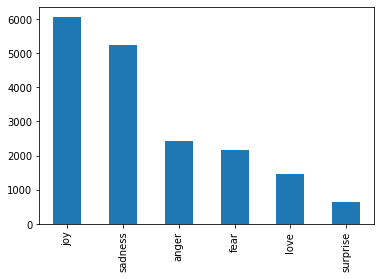

In [71]:
emotion_df_train = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
emotion_df_train['is_test'] = False
emotion_df_test = pd.read_csv(test_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
emotion_df_test['is_test'] = True
emotion_df = pd.concat([emotion_df_train, emotion_df_test])

emotion_df.emotion.value_counts().plot.bar()

In [72]:
emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     18000 non-null  object
 1   emotion  18000 non-null  object
 2   is_test  18000 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 439.5+ KB


In [73]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['text']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    CategoryBlock
)

def get_x(x): return x.text0

dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('emotion'), splitter=ColSplitter(col='is_test'))
#dblock = DataBlock(blocks=blocks, get_x=get_x, get_y=ColReader('emotion'), splitter=RandomSplitter(0.2))

dls = dblock.dataloaders(emotion_df, bs=4)

In [83]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=5)

,text,category
0,i just feel you so so dont be afraid naega deo apaya hae and pray again dasi neol chajeul su itge sigani heureulsurok gaseumi apawa i need you go back in time dan hanbeon manirado forgive my sins wo doedollil suman itdamyeon i gotong ttawin naegen so so sloth,fear
1,i am happier this year in all ways i am just glad i am on english lit only i made good module choices i like my teachers the peeps in my class are not so snidey i feel more confident in my work and i am on top of it unlike last year when i was soooooooooooo behind to the point of doing zero,joy
2,i get scared i feel ignored i feel happy i get silly i choke on my own words i make wishes i have dreams and i still want to believe anything can happen in this world for an ordinary girl like you like me for an ordinary girl like you like me how are you,sadness
3,i also feel a little resentful of the fact that im spending what are supposed to be some of the best years of my life taking care of other people while what little social life i have atrophies because im left without the time or energy to maintain it,anger


In [84]:

learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
                cbs=[HF_BaseModelCallback],
                splitter=hf_splitter)

learn.create_opt() 
learn.freeze()

learn.fit_one_cycle(3, lr_max=1e-3)

KeyboardInterrupt: ignored

In [87]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=5)

,text,category,target
0,i feel i am appreciative i take care of the baby i try to keep the apt clean as much as possible and i try not to call him a million times to find out when hell be home it varies from day to day as he is sort of self employed so its hard to plan things around his schedule,joy,anger
1,i was feeling like i said humour gets me through im one of those people who even if i spoke about my issues no one would be too bothered or would care that thought was in my head and wasnt true that way of being like i dont want to burden you sort of thing,anger,anger
2,i would say no not yet and i would feel superior and in fact self righteous even if i would not admit it back then because i remember looking at the point so i can see that the point did come up but i could did not face it to protect my ego,joy,anger
3,i think your viewers tonight will enjoy the show coming from malm they will like some things be less fond of other things but hopefully they will feel entertained and smitten and feel the urge to cast a vote regardless if your country is voting tonight or not,joy,anger


In [88]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6, 1e-3))

KeyboardInterrupt: ignored

IndexError: ignored

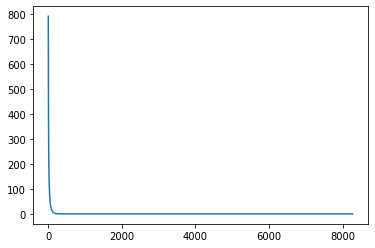

In [85]:
learn.recorder.plot_loss()